In [1]:
%matplotlib tk
import numpy as np
import hyperspy.api as hs
import pycrystem as pc
import pymatgen as pmg
from matplotlib import pyplot as plt
from pymatgen.transformations.standard_transformations import RotationTransformation
from pycrystem.indexation_generator import IndexationGenerator
from pycrystem.utils.expt_utils import radial_average
from scipy.constants import pi

In [2]:
si = pmg.Element("Si")
lattice = pmg.Lattice.cubic(5.431)
silicon = pmg.Structure.from_spacegroup("Fd-3m",lattice, [si], [[0, 0, 0]])

In [3]:
size = 256
radius=1.5
ediff = pc.ElectronDiffractionCalculator(300., 0.025)

rotaxis,thetas = [0, 0, 1],np.arange(0, 45, 1)
data_silicon = []
for theta in thetas:
    sieg = RotationTransformation(rotaxis, theta).apply_transformation(silicon)
    dpi = ediff.calculate_ed_data(sieg, radius).as_signal(256, 0.03, 1.2)
    data_silicon.append(dpi.data)
    
data = [data_silicon]
test_data = pc.ElectronDiffraction(data)
test_data.set_calibration(1.2/128)

In [4]:
rot_list = []
nstep=119
#np.linspace(0)
for i in np.arange(nstep):
    theta = (i*59.5/(nstep-1))/180*pi
    rot_list.append((theta, 0., 0.))

In [5]:
edc = pc.ElectronDiffractionCalculator(300, 0.025)
diff_gen = pc.DiffractionLibraryGenerator(edc)
struc_lib = dict()
struc_lib['si'] = (silicon, rot_list)
library = diff_gen.get_diffraction_library(struc_lib,
                                            calibration=1.2/128,
                                            reciprocal_radius=1.5,
                                            representation='euler')

In [6]:
### Ground Truth
indexer = IndexationGenerator(test_data, library)
match_results = indexer.correlate()

A Jupyter Widget

In [14]:
def _convert_to_2D(peak_locations):
    #if np.any(peak_locations[:,2] > 5e-2):
    #    print("This will be a warning in future, but be aware that you may not be within a 2D regime")
    peak_locations = peak_locations[:,0:2]
    return peak_locations

_phase = 'si'

def function_version_1(single):
    best_fit = single[0][1:4]
    best_fit_pattern = library[_phase][(best_fit[0],best_fit[1],best_fit[2])]
    peak_locations = best_fit_pattern.coordinates
    peak_locations = _convert_to_2D(best_fit_pattern.coordinates)
    return peak_locations

found_peaks = match_results.map(function_version_1,inplace=False,show_progressbar=False)
#from pycrystem.diffraction_vectors import DiffractionVectors
#found_peaks = DiffractionVectors(found_peaks)
#found_peaks.axes_manager.set_signal_dimension(0)
#found_peaks = found_peaks.transpose(navigation_axes=2)
#found_peaks = DiffractionVectors(found_peaks)

In [19]:
from matplotlib import pyplot as plt
peaks = test_data.find_peaks('laplacian_of_gaussians').inav[0,0]

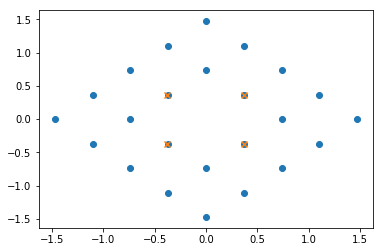

In [36]:
x_fp = found_peaks.inav[0,0].data[:,0]
y_fp = found_peaks.inav[0,0].data[:,1]
%matplotlib inline
plt.scatter(y_fp,x_fp)
plt.scatter(peaks.data[:,1],peaks.data[:,0],marker='x')